In [2]:
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

from data.data_generators import *
import torch


def get_available_gpu_with_most_memory():
    gpu_memory = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch to the GPU to accurately measure memory
        gpu_memory.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
    
    gpu_memory.sort(key=lambda x: x[1], reverse=True)
    
    return gpu_memory[0][0]

if torch.cuda.is_available():
    available_gpu = get_available_gpu_with_most_memory()
    if available_gpu == 0:
        device_wta = torch.device("cuda:0")
        device_cnp = torch.device("cuda:0")
    else:
        device_wta = torch.device(f"cuda:{available_gpu}")
        device_cnp = torch.device(f"cuda:{available_gpu}")
else:
    device_wta = torch.device("cpu")
    device_cnp = torch.device("cpu")

print("Device WTA:", device_wta, "Device CNP:", device_cnp)

###

torch.set_float32_matmul_precision('high')

Device WTA: cuda:0 Device CNP: cuda:0


In [3]:
batch_size = 3
n_max_obs, n_max_tar = 10, 10

t_steps = 200
num_demos = 3
num_classes = 3
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 3
num_val_indiv = num_val//num_classes

colors = ['tomato', 'aqua', 'limegreen', 'gold']

X: torch.Size([3, 200, 1]) Y: torch.Size([3, 200, 1]) VX: torch.Size([3, 200, 1]) VY: torch.Size([3, 200, 1])


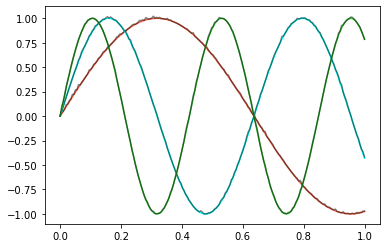

In [4]:
x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
# dum_x = torch.linspace(0, 1, 220).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

for i in range(num_classes):
    start_ind = i*num_indiv
    coeff = (i+1)/2*torch.pi
    y[start_ind:start_ind+num_indiv] = torch.unsqueeze(generate_sin(x*coeff), 2)

    noise = torch.unsqueeze(torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - noise_clip, -1)

    start_ind = i*num_val_indiv
    vy[start_ind:start_ind+num_indiv] = y[start_ind:start_ind+num_indiv].clone() + noise  # num_indiv = num_val_indiv

# coeff = 2*torch.pi
# y[:num_indiv] = torch.unsqueeze(generate_sin(x*coeff), 2)
# coeff = torch.pi
# y[num_indiv:] = torch.unsqueeze(generate_sin(x*coeff), 2)

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

from matplotlib import pyplot as plt

for i in range(num_demos):
    plt.plot(x[i, :, 0].cpu(), y[i, :, 0].cpu(), colors[i//num_indiv], f'Mod {i}')
    # plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), 'k', alpha=0.5)
    

x0, y0 = x.to(device_wta), y.to(device_wta)
x1, y1 = x.to(device_cnp), y.to(device_cnp)

In [5]:
def get_batch(x, y, traj_ids, device=device_wta):
    n_o = torch.randint(1, n_max_obs, (1,)).item()
    n_t = torch.randint(1, n_max_tar, (1,)).item()
    
    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)
    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    return obs, tar, tar_val

def get_validation_batch(vx, vy, traj_ids, device=device_wta):
    num_obs = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, num_obs, dx+dy, device=device)
    tar = torch.zeros(batch_size, t_steps, dx, device=device)
    tar_val = torch.zeros(batch_size, t_steps, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:num_obs]

        obs[i, :, :] = torch.cat((vx[traj_ids[i], o_ids], vy[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = vx[traj_ids[i]]
        tar_val[i, :, :] = vy[traj_ids[i]]

    return obs, tar, tar_val

In [8]:
model_wta = WTA_CNP(1, 1, n_max_obs, n_max_tar, [150, 150, 150], num_decoders=3, decoder_hidden_dims=[150, 150, 150], batch_size=batch_size, scale_coefs=True).to(device_wta)
optimizer_wta = torch.optim.Adam(lr=1e-4, params=model_wta.parameters())

model_cnp = CNP(input_dim=1, hidden_dim=216, output_dim=1, n_max_obs=n_max_obs, n_max_tar=n_max_tar, num_layers=3, batch_size=batch_size).to(device_cnp)
optimizer_cnp = torch.optim.Adam(lr=1e-4, params=model_cnp.parameters())

# print("WTA Model:", model_wta)

In [9]:
def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("WTA-CNP:", get_parameter_count(model_wta))
print("CNP:", get_parameter_count(model_cnp))

if torch.__version__ >= "2.0":
    model_cnp, model_wta = torch.compile(model_cnp), torch.compile(model_wta)

WTA-CNP: 183459
CNP: 188786


In [10]:
from matplotlib.lines import Line2D


def draw_val_plot(root_folder, epoch):
    plt_y_lim = torch.max(vy) + 0.1

    obs = torch.zeros((model_wta.num_decoders, 1, 1, 2)).to(device_wta)
    for i in range(batch_size):
        obs[i] = torch.Tensor([x[i, 80, 0], y[i, 80, 0]]).unsqueeze(0).unsqueeze(0).to(device_wta)

    tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).to(device_wta)

    with torch.no_grad():
        for i in range(batch_size):
            pred_cnp, _ = model_cnp(obs[i], tar)
            pred_wta, gate = model_wta(obs[i], tar)

            plt.ylim((-plt_y_lim, plt_y_lim))
            plt.scatter(obs[i,:,:,0].cpu(), obs[i,:,:,1].cpu(), c='k')
            for j in range(batch_size):
                plt.plot(torch.linspace(0, 1, 200), pred_wta[j,0,:,0].cpu(), colors[j], alpha=max(0.2, gate[0, 0, j].item()))  # wta pred
            plt.plot(torch.linspace(0, 1, 200), pred_cnp[:, :, :model_cnp.output_dim].squeeze(0).cpu(), 'b')  # cnp pred
            handles = []
            for j in range(batch_size):
                plt.plot(torch.linspace(0, 1, 200), vy[j].squeeze(-1).cpu(), 'k', alpha=0.05 if j!=i else 0.35)  # data
                handles.append(Line2D([0], [0], label=f'gate{j}: {gate[0, 0, j].item():.4f}', color=colors[j]))

            plt.legend(handles=handles, loc='upper right')

            plt.savefig(f'{root_folder}img/{i}_{epoch}.png')
            plt.close()

In [11]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/sine/3_sines/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 1_500_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss_wta, avg_loss_cnp = 0, 0

val_per_epoch = 1000
min_val_loss_wta, min_val_loss_cnp = 1000000, 1000000

mse_loss = torch.nn.MSELoss()

training_loss_wta, validation_error_wta = [], []
training_loss_cnp, validation_error_cnp = [], []

wta_tr_loss_path = f'{root_folder}wta_training_loss.pt'
wta_val_err_path = f'{root_folder}wta_validation_error.pt'
cnp_tr_loss_path = f'{root_folder}cnp_training_loss.pt'
cnp_val_err_path = f'{root_folder}cnp_validation_error.pt'

for epoch in range(epochs):
    epoch_loss_wta, epoch_loss_cnp = 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer_wta.zero_grad()
        optimizer_cnp.zero_grad()

        obs_wta, tar_x_wta, tar_y_wta = get_batch(x, y, traj_ids[i], device_wta)
        obs_cnp, tar_x_cnp, tar_y_cnp = obs_wta.clone(), tar_x_wta.clone(), tar_y_wta.clone()

        pred_wta, gate_wta = model_wta(obs_wta, tar_x_wta)
        pred_cnp, encoded_rep_cnp = model_cnp(obs_cnp, tar_x_cnp)

        loss_wta, wta_nll = model_wta.loss(pred_wta, gate_wta, tar_y_wta)

        loss_wta.backward()
        optimizer_wta.step()

        loss_cnp = model_cnp.loss(pred_cnp, tar_y_cnp)
        loss_cnp.backward()
        optimizer_cnp.step()

        epoch_loss_wta += wta_nll.item()
        epoch_loss_cnp += loss_cnp.item()

    training_loss_wta.append(epoch_loss_wta)
    training_loss_cnp.append(epoch_loss_cnp)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss_wta, val_loss_cnp = 0, 0

            for j in range(v_epoch_iter):
                o_wta, t_wta, tr_wta = get_validation_batch(vx, vy, v_traj_ids[j], device=device_wta)
                o_cnp, t_cnp, tr_cnp = o_wta.clone(), t_wta.clone(), tr_wta.clone()

                p_wta, g_wta = model_wta(o_wta, t_wta)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss_wta += mse_loss(vp_means, tr_wta).item()

                pred_cnp, encoded_rep = model_cnp(o_cnp, t_cnp)
                val_loss_cnp += mse_loss(pred_cnp[:, :, :model_cnp.output_dim], tr_cnp)


            validation_error_wta.append(val_loss_wta)
            if val_loss_wta < min_val_loss_wta:
                min_val_loss_wta = val_loss_wta
                print(f'(WTA)New best: {min_val_loss_wta}')
                torch.save(model_wta.state_dict(), f'{root_folder}saved_models/wta_on_synth.pt')

            validation_error_cnp.append(val_loss_cnp.item())
            if val_loss_cnp < min_val_loss_cnp:
                min_val_loss_cnp = val_loss_cnp
                print(f'(CNP)New best: {min_val_loss_cnp}')
                torch.save(model_cnp.state_dict(), f'{root_folder}saved_models/cnp_on_synth.pt')
  
        draw_val_plot(root_folder, epoch)


    avg_loss_wta += epoch_loss_wta
    avg_loss_cnp += epoch_loss_cnp

    if epoch % 100 == 0:
        print("Epoch: {}, WTA-Loss: {}, CNP-Loss: {}".format(epoch, avg_loss_wta/100, avg_loss_cnp/100))
        avg_loss_wta, avg_loss_cnp = 0, 0

torch.save(torch.Tensor(training_loss_wta), wta_tr_loss_path)
torch.save(torch.Tensor(validation_error_wta), wta_val_err_path)
torch.save(torch.Tensor(training_loss_cnp), cnp_tr_loss_path)
torch.save(torch.Tensor(validation_error_cnp), cnp_val_err_path)

(WTA)New best: 0.5034494400024414
(CNP)New best: 0.5106316208839417
Epoch: 0, WTA-Loss: 0.010265804529190063, CNP-Loss: 0.010363631248474121
Epoch: 100, WTA-Loss: 1.0583095014095307, CNP-Loss: 1.0614046651124953
Epoch: 200, WTA-Loss: 1.0453639507293702, CNP-Loss: 1.0471319031715394
Epoch: 300, WTA-Loss: 1.0508523589372636, CNP-Loss: 1.0525869101285934
Epoch: 400, WTA-Loss: 1.028581481575966, CNP-Loss: 1.0318665254116057
Epoch: 500, WTA-Loss: 1.0237284576892853, CNP-Loss: 1.0256542605161667
Epoch: 600, WTA-Loss: 1.0250414890050887, CNP-Loss: 1.0245136278867721
Epoch: 700, WTA-Loss: 1.0184539991617203, CNP-Loss: 1.0122505021095276
Epoch: 800, WTA-Loss: 1.055182992219925, CNP-Loss: 1.0363528829813005
Epoch: 900, WTA-Loss: 1.032776403427124, CNP-Loss: 1.0040965265035628
(WTA)New best: 0.44256073236465454
(CNP)New best: 0.4275665283203125
Epoch: 1000, WTA-Loss: 1.0012793719768525, CNP-Loss: 0.9669282501935959
Epoch: 1100, WTA-Loss: 1.017421714067459, CNP-Loss: 0.9712689387798309
Epoch: 1200

KeyboardInterrupt: 

In [ ]:
open(f'{root_folder}fin', 'w').close()